<a href="https://colab.research.google.com/github/heetaekshin/Hyundai-Motor-Company-Stock-Price/blob/main/CP1_%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CP1 주가분석 #

## 프로젝트 목적 ##

머신러닝, 딥러닝 기법을 적용한 주가예측모델을 생성함으로써 관심종목에 대한 기대수익을 제시 및 투자 참고자료로 활용

## 데이터셋 ##

### 데이터셋 정보 ###

**Huge Stock Market Dataset** (https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs)
* NYSE, NASDAQ, NYSE MKT에서 거래되는 미국 기반의 주식 및 ETF의 거래 데이터(10,783개)
* 구성
 - 날짜: 상장 ~ 2017. 11. 10
 - Open(시가), High(고가), Low(저가), Close(종가), Volume(거래량), OpenInt

### 데이터셋 불러오기 ###

In [ ]:
!pip install tools

     |████████████████████████████████| 89 kB 5.7 MB/s 
  Created wheel for tools: filename=tools-0.1.9-py3-none-any.whl size=46756 sha256=b9da5fb31aaccf08757802ddda38cc7efcaad54a0469d8573142c2d519d24dc6
  Stored in directory: /root/.cache/pip/wheels/32/f1/c1/7b783d8f54066026fa6b442246d52664df9db01ed64d6eb096
  Created wheel for pytils: filename=pytils-0.3-py3-none-any.whl size=40378 sha256=fc4d1692d9d7823241e115300c03ccf998e92b8c92848ded30ff854ac9524d59
  Stored in directory: /root/.cache/pip/wheels/f4/83/0e/26136b84fd9f5456bf1c8d5f5550fa15ef9d4cb5c3d78a400e
Successfully built tools pytils


In [ ]:
!pip install chainer

     |████████████████████████████████| 1.0 MB 6.6 MB/s 
  Created wheel for chainer: filename=chainer-7.8.0-py3-none-any.whl size=967734 sha256=1e867ab05716bedbd1b15c486aa9139b47a5f21785c4ffb4352a54b5768b8fc7
  Stored in directory: /root/.cache/pip/wheels/8d/45/4c/c961846626d4db2511e4acbd5056eefb2aeedcec8208a3ca42
Successfully built chainer


In [ ]:
import pandas as pd # 데이터프레임 처리

import matplotlib.pyplot as plt
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import iplot, iplot_mpl

import chainer # chainer: 복잡한 신경망 네크워크 아키텍처를 수비고 직관적으로 작성하는 프레임워크
import chainer.functions as F
import chainer.links as L

import copy
import time

/usr/local/lib/python3.7/dist-packages/chainer/_environment_check.py:75: UserWarning:


--------------------------------------------------------------------------------
CuPy (cupy-cuda111) version 9.4.0 may not be compatible with this version of Chainer.
Please consider installing the supported version by running:
  $ pip install 'cupy-cuda111>=7.7.0,<8.0.0'

See the following page for more details:
  https://docs.cupy.dev/en/latest/install.html
--------------------------------------------------------------------------------




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 록히드마틴(미국 방위산업체) 주식데이터
lmt_data = pd.read_csv('/content/drive/MyDrive/CP1_Dataset/Stocks/lmt.us.txt')
lmt_data['Date'] = pd.to_datetime(lmt_data['Date'])
lmt_data = lmt_data.set_index('Date')
lmt_data

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1977-01-03,0.7388,0.7466,0.7388,0.7466,26460,0
1977-01-04,0.7466,0.7545,0.7077,0.7466,29387,0
1977-01-05,0.7466,0.7702,0.7466,0.7702,31420,0
1977-01-06,0.7702,0.8098,0.7702,0.8098,56612,0
1977-01-07,0.8098,0.8175,0.8020,0.8175,48724,0
...,...,...,...,...,...,...
2017-11-06,309.7200,311.9300,308.6800,310.0800,717284,0
2017-11-07,310.0800,313.3700,310.0800,313.2900,874379,0
2017-11-08,313.4400,315.7000,313.3000,315.6400,729698,0


## EDA, Preprocessing ##

### EDA ###

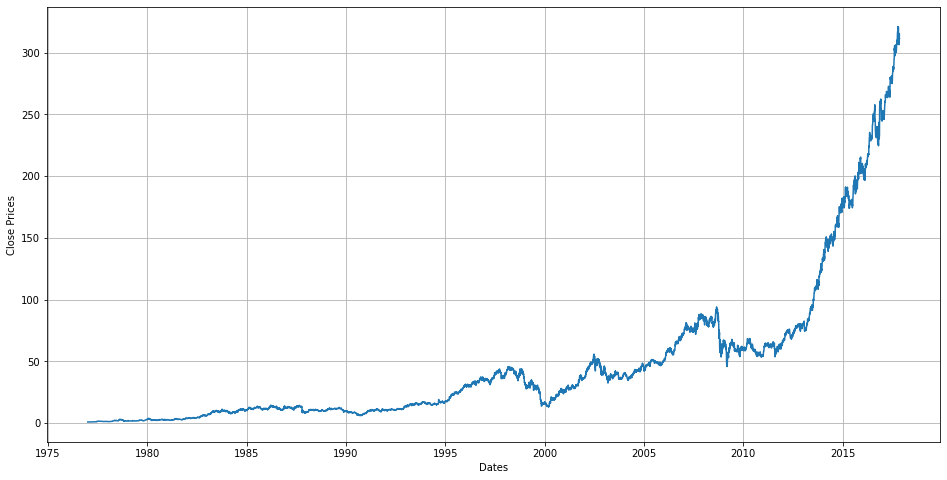

In [ ]:
# 데이터 시각화를 통한 추세파악
plt.figure(figsize=(16, 8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(lmt_data['Close'])

In [ ]:
date_split = '2016-01-01'
lmt_train = lmt_data[:date_split]
lmt_test = lmt_data[date_split:]
len(lmt_train), len(lmt_test)

(9834, 470)

In [ ]:
def plot_train_test(train, test, date_split):
    '''
    plotly 라이브러리의 Candlestick을 활용한 시각화
    녹색: 상승
    적색: 하락
    '''
    data = [
        Candlestick(x=train.index, open=train['Open'], high=train['High'], low=train['Low'], close=train['Close'], name='train'),
        Candlestick(x=test.index, open=test['Open'], high=test['High'], low=test['Low'], close=test['Close'], name='test')
    ]
    layout = {
         'shapes': [
             {'x0': date_split, 'x1': date_split, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}
         ],
        'annotations': [
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': ' test data'},
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data '}
        ]
    }
    figure = Figure(data=data, layout=layout)
    iplot(figure)

In [ ]:
plot_train_test(lmt_train, lmt_test, date_split)

2010-01-01년 이후 데이터로 변환

In [ ]:
lmt_2010 = lmt_data['2010-01-01':]
lmt_2010

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2010-01-04,59.642,60.489,59.364,60.412,3063235,0
2010-01-05,60.230,61.148,60.174,61.038,2997775,0
2010-01-06,59.821,60.678,59.625,60.143,6624366,0
2010-01-07,59.875,59.899,57.864,58.491,8953827,0
2010-01-08,58.446,59.695,58.422,59.435,4617000,0
...,...,...,...,...,...,...
2017-11-06,309.720,311.930,308.680,310.080,717284,0
2017-11-07,310.080,313.370,310.080,313.290,874379,0
2017-11-08,313.440,315.700,313.300,315.640,729698,0


In [ ]:
lmt_2010_train = lmt_2010[:date_split]
lmt_2010_test = lmt_2010[date_split:]
len(lmt_2010_train), len(lmt_2010_test)

(1510, 470)

In [ ]:
plot_train_test(lmt_2010_train, lmt_2010_test, date_split)

```iplot 라이브러리를 사용하면서 그래프가 이미지 파일로만 인식하여 데이터를 2010년 이후로 조정하는 작업을 수행했다. \
하지만 iplot은 인터렉티브한 그래프 성능을 제공하기 때문에 본래의 lmt_data를 활용하여 분석을 진행할 것이다.```

### Preprocessing ###

## 기존 모델: LSTM ##

Section4 프로젝트에서 수행한 삼성전자 주가예측 모델링에서 사용한 LSTM모델을 록히드마틴 주가 데이터에 적용

### 데이터셋 표준화 ###

In [ ]:
#라이브러리
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

import numpy as np

In [ ]:
# MinMaxScaling: 데이터 값을 0 ~ 1 사이의 값으로 변환
def MinMaxScaler(data):
    n = data - np.min(data, 0)
    d = np.max(data, 0) - np.min(data, 0)
    return n / (d + 1e-7)

In [ ]:
# 특성 데이터와 타겟 데이터 분리
lmt_x = lmt_data[['Open', 'High', 'Low', 'Volume', 'Close']]
lmt_x = MinMaxScaler(lmt_x)
lmt_y = lmt_x[['Close']]

x = lmt_x.values.tolist()
y = lmt_y.values.tolist()

In [ ]:
# lmt_x 정보
lmt_x.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10304 entries, 1977-01-03 to 2017-11-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    10304 non-null  float64
 1   High    10304 non-null  float64
 2   Low     10304 non-null  float64
 3   Volume  10304 non-null  float64
 4   Close   10304 non-null  float64
dtypes: float64(5)
memory usage: 803.0 KB


In [ ]:
# lmt_y 정보
lmt_y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10304 entries, 1977-01-03 to 2017-11-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   10304 non-null  float64
dtypes: float64(1)
memory usage: 481.0 KB


In [ ]:
# lmt_x, lmt_y 마지막에 저장된 값 출력
lmt_x[-6:], lmt_y[-6:]

(                Open      High       Low    Volume     Close
 Date                                                        
 2017-11-03  0.966657  0.967840  0.966052  0.032080  0.965172
 2017-11-06  0.962917  0.968083  0.964939  0.035279  0.965453
 2017-11-07  0.964039  0.972563  0.969326  0.043006  0.975471
 2017-11-08  0.974510  0.979811  0.979415  0.035890  0.982805
 2017-11-09  0.978903  0.977820  0.969953  0.043752  0.968574
 2017-11-10  0.964725  0.967305  0.968323  0.031028  0.968855,
                Close
 Date                
 2017-11-03  0.965172
 2017-11-06  0.965453
 2017-11-07  0.975471
 2017-11-08  0.982805
 2017-11-09  0.968574
 2017-11-10  0.968855)

In [ ]:
# LSTM모델 적용을 위한 데이터셋 준비
lmt_x_data = []
lmt_y_data = []
window_size = 10 # 이전 10일의 데이터를 활용하여 다음날 종가를 예측하기 위한 변수
for i in range(len(lmt_y) - window_size):
    _x = x[i : i + window_size]
    _y = y[i + window_size]
    lmt_x_data.append(_x)
    lmt_y_data.append(_y)

print(_x, '->', _y) # 리스트에 추가된 마지막 값 확인

[[0.9574016831297884, 0.9632456670286896, 0.9620255898137011, 0.049118008000040285, 0.9589619972621686], [0.9580560830183988, 0.9633856539072093, 0.9622449139631325, 0.05692898366767799, 0.9609280764658359], [0.9611722729641627, 0.9615658244864531, 0.9632475386462473, 0.03412473175439238, 0.9594613189646873], [0.9608294920701287, 0.9610214310699877, 0.9572631225689051, 0.04997539058198261, 0.95459293236513], [0.9516678936295828, 0.9647544144971797, 0.9568871383127371, 0.04273638038275973, 0.9678873726946903], [0.9666567672687072, 0.9678403474636585, 0.9660517545568347, 0.03207998840428406, 0.9651723109372449], [0.9629173393337905, 0.968082991386426, 0.964939467799004, 0.035279188154309214, 0.9654531793949116], [0.9640391677142655, 0.9725625714990564, 0.9693259507876317, 0.04300581256402866, 0.975470821051693], [0.9745095659320322, 0.9798107809868543, 0.979414861661476, 0.035889763382179335, 0.9828046085574362], [0.9789033937555593, 0.9778198564923519, 0.9699525912145786, 0.043752185939

In [ ]:
# Train/Test 분리
# date_split = '2016-01-01' (1510번째 데이터)
# Train data
lstm_train_x = np.array(lmt_x_data[0:9824])
lstm_train_y = np.array(lmt_y_data[0:9824])
# Test data
lstm_test_x = np.array(lmt_x_data[9824:len(lmt_x_data)])
lstm_test_y = np.array(lmt_y_data[9824:len(lmt_y_data)])

len(lstm_train_y), len(lstm_test_y)

(9824, 470)

### 모델링 ###

In [ ]:
# 모델 생성: LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=10, return_sequences=False, input_shape=(window_size,5)))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=10))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                640       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 10)                110       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 761
Trainable params: 761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 학습 및 예측
model_lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model_lstm.fit(lstm_train_x, lstm_train_y, epochs=30, batch_size=32)
pred_lstm_y = model_lstm.predict(lstm_test_x)

Epoch 1/30
307/307 [==============================] - 5s 3ms/step - loss: 0.0029 - mae: 0.0306
Epoch 2/30
307/307 [==============================] - 1s 3ms/step - loss: 0.0013 - mae: 0.0216
Epoch 3/30
307/307 [==============================] - 1s 3ms/step - loss: 0.0010 - mae: 0.0197
Epoch 4/30
307/307 [==============================] - 1s 3ms/step - loss: 9.8481e-04 - mae: 0.0189
Epoch 5/30
307/307 [==============================] - 1s 3ms/step - loss: 8.7995e-04 - mae: 0.0183
Epoch 6/30
307/307 [==============================] - 1s 3ms/step - loss: 9.6447e-04 - mae: 0.0185
Epoch 7/30
307/307 [==============================] - 1s 3ms/step - loss: 9.2122e-04 - mae: 0.0186
Epoch 8/30
307/307 [==============================] - 1s 3ms/step - loss: 8.8927e-04 - mae: 0.0181
Epoch 9/30
307/307 [==============================] - 1s 3ms/step - loss: 9.2348e-04 - mae: 0.0184
Epoch 10/30
307/307 [==============================] - 1s 3ms/step - loss: 8.9888e-04 - mae: 0.0182
Epoch 11/30
307/307 [

### 시각화 ###

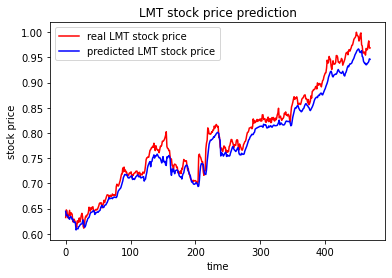

In [ ]:
plt.figure()
plt.plot(lstm_test_y, color='red', label='real LMT stock price')
plt.plot(pred_lstm_y, color='blue', label='predicted LMT stock price')
plt.title('LMT stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

In [ ]:
# 예측 종가
int(lmt_data.Close[-1]*pred_lstm_y[-1]/lmt_y.Close[-1])

303

In [ ]:
# 실제 종가
lmt_data.Close[-1]

311.17

```
모델을 LMT 주식에 대입하였으나, 예측 종가에서는 -30의 가격차이가 발생하였다.
그래프를 통해 예측된 가격은 전체적으로 비슷한 수준에서 하향 예측된 것을 확인할 수 있다.
```

## 강화학습(DQN) ##

주가의 예측은 실제 값과 차이가 나기 때문에 종가에 대한 전일비를 바탕으로 '매수', '매도', '보유'로 나누어 이를 예측하고 제안해주는 모델을 구축하는 것이 이번 프로젝트의 목표이다.

### 환경 선언 ###

In [ ]:
class Environment:

    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()

    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # observations

    def step(self, act):
        reward = 0

        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            self.positions.append(self.data.iloc[self.t, :]['Close'])
        elif act == 2:
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []

        # set next time
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t - 1), :]['Close'])

        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1

        return [self.position_value] + self.history, reward, self.done # observation, reward, done

In [ ]:
env = Environment(lmt_train)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(3)
    print(env.step(pact))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0], -1, False)
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.023599999999999954], -1, False)
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### DQN(Deep Q-Network) ###

In [ ]:
def train_dqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                function1 = L.Linear(input_size, hidden_size),
                function2 = L.Linear(hidden_size, hidden_size),
                function3 = L.Linear(hidden_size, output_size)
            )
        
        def __call__(self, x):
            h = F.relu(self.function1(x))
            h = F.relu(self.function2(h))
            y = self.function3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 50
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:
            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done = env.step(pact)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update Q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j] + gamma * maxq[j] * (not b_done[j])
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()
                
                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):]) / show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time() - start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))

    return Q, total_losses, total_rewards

In [ ]:
Q, total_losses, total_rewards = train_dqn(Environment(lmt_train))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



5	0.0999999999999992	49165	213.2	965.3150365712005	456.461040019989
10	0.0999999999999992	98330	263.6	277.04288883797125	919.4889843463898
15	0.0999999999999992	147495	539.4	415.7379655839992	1408.109462738037
20	0.0999999999999992	196660	-32.8	157.19843006798928	2027.7876121997833
25	0.0999999999999992	245825	-53.6	121.68918498806485	2634.7216081619263
30	0.0999999999999992	294990	-50.2	124.58004236549064	3268.0531108379364
35	0.0999999999999992	344155	-54.6	125.08764034483048	3895.695458650589
40	0.0999999999999992	393320	-55.8	129.85348247436264	4500.533922672272
45	0.0999999999999992	442485	-47.2	116.60014493926522	5145.414742469788
50	0.0999999999999992	491650	-47.0	122.09622199328183	5780.718101501465


In [ ]:
def plot_loss_reward(total_losses, total_rewards):

    figure = tools.make_subplots(rows=1, cols=2, subplot_titles=('loss', 'reward'), print_grid=False)
    figure.append_trace(Scatter(y=total_losses, mode='lines', line=dict(color='skyblue')), 1, 1)
    figure.append_trace(Scatter(y=total_rewards, mode='lines', line=dict(color='orange')), 1, 2)
    figure['layout']['xaxis1'].update(title='epoch')
    figure['layout']['xaxis2'].update(title='epoch')
    figure['layout'].update(height=400, width=900, showlegend=False)
    iplot(figure)

In [ ]:
plot_loss_reward(total_losses, total_rewards)

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [ ]:
def plot_train_test_by_q(train_env, test_env, Q, algorithm_name):
    
    # train
    pobs = train_env.reset()
    train_acts = []
    train_rewards = []

    for _ in range(len(train_env.data)-1):
        
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        train_acts.append(pact)
            
        obs, reward, done = train_env.step(pact)
        train_rewards.append(reward)

        pobs = obs
        
    train_profits = train_env.profits
    
    # test
    pobs = test_env.reset()
    test_acts = []
    test_rewards = []

    for _ in range(len(test_env.data)-1):
    
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        test_acts.append(pact)
            
        obs, reward, done = test_env.step(pact)
        test_rewards.append(reward)

        pobs = obs
        
    test_profits = test_env.profits
    
    # plot
    train_copy = train_env.data.copy()
    test_copy = test_env.data.copy()
    train_copy['act'] = train_acts + [np.nan]
    train_copy['reward'] = train_rewards + [np.nan]
    test_copy['act'] = test_acts + [np.nan]
    test_copy['reward'] = test_rewards + [np.nan]
    train0 = train_copy[train_copy['act'] == 0]
    train1 = train_copy[train_copy['act'] == 1]
    train2 = train_copy[train_copy['act'] == 2]
    test0 = test_copy[test_copy['act'] == 0]
    test1 = test_copy[test_copy['act'] == 1]
    test2 = test_copy[test_copy['act'] == 2]
    act_color0, act_color1, act_color2 = 'gray', 'cyan', 'magenta'

    data = [
        Candlestick(x=train0.index, open=train0['Open'], high=train0['High'], low=train0['Low'], close=train0['Close'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        Candlestick(x=train1.index, open=train1['Open'], high=train1['High'], low=train1['Low'], close=train1['Close'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1))),
        Candlestick(x=train2.index, open=train2['Open'], high=train2['High'], low=train2['Low'], close=train2['Close'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2))),
        Candlestick(x=test0.index, open=test0['Open'], high=test0['High'], low=test0['Low'], close=test0['Close'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        Candlestick(x=test1.index, open=test1['Open'], high=test1['High'], low=test1['Low'], close=test1['Close'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1))),
        Candlestick(x=test2.index, open=test2['Open'], high=test2['High'], low=test2['Low'], close=test2['Close'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2)))
    ]
    title = '{}: train s-reward {}, profits {}, test s-reward {}, profits {}'.format(
        algorithm_name,
        int(sum(train_rewards)),
        int(train_profits),
        int(sum(test_rewards)),
        int(test_profits)
    )
    layout = {
        'title': title,
        'showlegend': False,
         'shapes': [
             {'x0': date_split, 'x1': date_split, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}
         ],
        'annotations': [
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': ' test data'},
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data '}
        ]
    }
    figure = Figure(data=data, layout=layout)
    iplot(figure)

In [ ]:
plot_train_test_by_q(Environment(lmt_train), Environment(lmt_test), Q, 'DQN')

### DDQN(Double Deep Q-Network ###

In [ ]:
def train_ddqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 50
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 50
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done = env.step(pact)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        """ <<< DQN -> Double DQN
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        === """
                        indices = np.argmax(q.data, axis=1)
                        maxqs = Q_ast(b_obs).data
                        """ >>> """
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            """ <<< DQN -> Double DQN
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                            === """
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])
                            """ >>> """
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
    return Q, total_losses, total_rewards

In [ ]:
Q, total_losses, total_rewards = train_ddqn(Environment(lmt_train))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



5	0.0999999999999992	49165	314.0	59.261636570626436	340.2858076095581
10	0.0999999999999992	98330	485.6	95.1944957830754	291.7408995628357
15	0.0999999999999992	147495	497.2	23.648566873755406	290.2614731788635
20	0.0999999999999992	196660	421.6	18.781596022500093	279.3983678817749
25	0.0999999999999992	245825	434.0	17.642581920597785	281.259934425354
30	0.0999999999999992	294990	549.2	17.696095896431917	287.01763892173767
35	0.0999999999999992	344155	521.8	17.350876012382834	286.6517713069916
40	0.0999999999999992	393320	476.8	14.743413970859866	281.75974130630493
45	0.0999999999999992	442485	373.4	12.833025778505725	280.3097310066223
50	0.0999999999999992	491650	360.0	10.724088791702115	278.78302693367004


In [ ]:
plot_loss_reward(total_losses, total_rewards)

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [ ]:
plot_train_test_by_q(Environment(lmt_train), Environment(lmt_test), Q, 'Double DQN')

### Dueling DDQN ###

In [ ]:
def train_dddqn(env):

    """ <<< Double DQN -> Dueling Double DQN
    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()
    === """
    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, hidden_size//2),
                fc4 = L.Linear(hidden_size, hidden_size//2),
                state_value = L.Linear(hidden_size//2, 1),
                advantage_value = L.Linear(hidden_size//2, output_size)
            )
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            hs = F.relu(self.fc3(h))
            ha = F.relu(self.fc4(h))
            state_value = self.state_value(hs)
            advantage_value = self.advantage_value(ha)
            advantage_mean = (F.sum(advantage_value, axis=1)/float(self.output_size)).reshape(-1, 1)
            q_value = F.concat([state_value for _ in range(self.output_size)], axis=1) + (advantage_value - F.concat([advantage_mean for _ in range(self.output_size)], axis=1))
            return q_value

        def reset(self):
            self.zerograds()
    """ >>> """

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 50
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 50
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done = env.step(pact)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        """ <<< DQN -> Double DQN
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        === """
                        indices = np.argmax(q.data, axis=1)
                        maxqs = Q_ast(b_obs).data
                        """ >>> """
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            """ <<< DQN -> Double DQN
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                            === """
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])
                            """ >>> """
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
    return Q, total_losses, total_rewards

In [ ]:
Q, total_losses, total_rewards = train_dddqn(Environment(lmt_train))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



5	0.0999999999999992	49165	242.2	36.29115514394798	487.45421028137207
10	0.0999999999999992	98330	244.8	27.01212867195718	481.4271776676178
15	0.0999999999999992	147495	169.6	21.007653038289938	468.84051156044006
20	0.0999999999999992	196660	124.8	13.690354222161114	464.97702860832214
25	0.0999999999999992	245825	133.8	12.428431797059238	465.5192770957947
30	0.0999999999999992	294990	52.4	14.675350512606405	464.31884956359863
35	0.0999999999999992	344155	-16.2	9.653895358695626	464.8899772167206
40	0.0999999999999992	393320	0.0	12.018180264431322	461.2670741081238
45	0.0999999999999992	442485	-26.4	13.272591522687161	477.54924845695496
50	0.0999999999999992	491650	23.0	13.446641036345852	461.736123085022


In [ ]:
plot_loss_reward(total_losses, total_rewards)

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [ ]:
plot_train_test_by_q(Environment(lmt_train), Environment(lmt_test), Q, 'Dueling Double DQN')

## 참고자료 ##
* DQN(Deep Q-Network), DDQN(Double Deep Q-Network)을 이용한 트레이딩 봇 구현 성능 및 비교(김민태, 김병욱 / 창원대학교) http://www.tkiee.org/kiee/XmlViewer/f401767
* 강화학습이 실제로 자산운용에 도움을 줄 수 있을까? https://medium.com/curg/%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5%EC%9D%B4-%EC%8B%A4%EC%A0%9C%EB%A1%9C-%EC%9E%90%EC%82%B0%EC%9A%B4%EC%9A%A9%EC%97%90-%EB%8F%84%EC%9B%80%EC%9D%84-%EC%A4%84-%EC%88%98-%EC%9E%88%EC%9D%84%EA%B9%8C-d00ad419810
* [도서] 파이썬 증권데이터 분석 (김황후, 한빛미디어)
* Deep Reinforcement Learning on Stock Data(GIN04KG) https://www.kaggle.com/itoeiji/deep-reinforcement-learning-on-stock-data